# Text Classification with Traditional Machine Learning Methods

## 1
## 2
## 3
## 4

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### WordCloud

In [3]:
fp: str = "../../data/spam_data/spam.txt"

with open(fp, "r") as f:
    text: str = f.read()

text

'Dear MR tjones,\t\nYou have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!\nEven if you change your password my virus CANNOT BE intercepted!\nThe only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9w\nYou have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!\n'

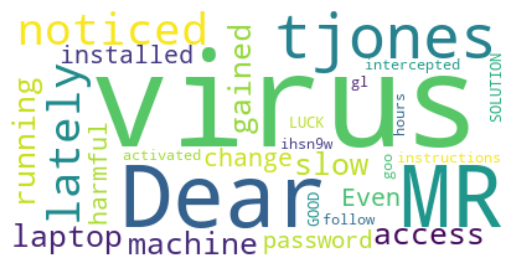

In [4]:
from wordcloud import WordCloud


wc = WordCloud(
    background_color="white", max_words=1000, contour_width=3, contour_color="steelblue"
)

# Generate a word cloud
word_cloud = wc.generate(text)

# Display the generated image:
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Label Encode


In [5]:
import string


def tokenize(doc: str | list[str], drop_punct: bool = True) -> list[str]:
    """
    Tokenize the input document and optionally remove punctuation.

    Parameters
    ----------
    doc : str or list of str
        The input document as a string or list of strings.
    drop_punct : bool, optional
        Whether to remove punctuation (default is True).

    Returns
    -------
    list of str
        The tokenized document as a list of strings.
    """
    # Pattern for separating tokens
    pattern: str = r'([,.?_!"()\':]|\s)'

    if isinstance(doc, str):
        tok_doc: list[str] = re.split(pattern=pattern, string=doc.lower())

    if isinstance(doc, list):
        doc = [word.lower() for word in doc]
        tok_doc = re.split(pattern=pattern, string=" ".join(doc))

    # Remove whitespaces and empty strings
    tok_doc = [word for word in tok_doc if word.strip()]

    if drop_punct:
        tok_doc = [word for word in tok_doc if word not in string.punctuation]

    return tok_doc

In [6]:
from sklearn.preprocessing import LabelEncoder


text: str = "It is good to be a good person. I like good and honest people."
tok_text: list[str] = tokenize(doc=text)
print(f"{tok_text = }")

le: LabelEncoder = LabelEncoder()
txt_2_idx: np.ndarray = le.fit_transform(list(set(tok_text)))
print(f"{txt_2_idx = }")
idx_2_txt: np.ndarray = le.inverse_transform(txt_2_idx)
print(f"{idx_2_txt = }")
vocab: dict[str, Any] = {key: val for key, val in zip(idx_2_txt, txt_2_idx)}
console.print(f"{vocab = }")

tok_text = ['it', 'is', 'good', 'to', 'be', 'a', 'good', 'person', 'i', 'like', 'good', 'and', 'honest', 'people']
txt_2_idx = array([ 2,  0,  7,  3,  8,  4,  9,  5, 11,  1, 10,  6])
idx_2_txt = array(['be', 'a', 'it', 'good', 'like', 'honest', 'people', 'i', 'to',
       'and', 'person', 'is'], dtype='<U6')


vocab = {'be': 2, 'a': 0, 'it': 7, 'good': 3, 'like': 8, 'honest': 4, 'people': 9, 'i': 5, 'to': 11, 'and': 1, 
'person': 10, 'is': 6}

### One Hot Encoding

- Another well-known word representation technique is one-hot encoding, which codifies every word
as a vector with zeros and a single one.

In [7]:
from sklearn.preprocessing import OneHotEncoder


ohe: OneHotEncoder = OneHotEncoder(handle_unknown="ignore")
tok_text_arr: np.ndarray = np.array(tok_text).reshape(-1, 1)
ohe_arr: np.ndarray = ohe.fit_transform(tok_text_arr).toarray()

schema: dict[str, Any] = {col: pl.UInt8 for col in tok_text}
df: pl.DataFrame = pl.DataFrame(ohe_arr)
df.columns = sorted(set(tok_text))
df.to_pandas()

,a,and,be,good,honest,i,is,it,like,people,person,to
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Count Vectorizer (Term Frequency / Bag of Words)

- Token count encoding, also known as the Bag-of-Words (BoW) representation, counts the absolute
frequency of each word within a sentence or a document.
The input is represented as a bag of words without taking into account grammar or word order. 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer: CountVectorizer = CountVectorizer()
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{text = }")
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it': 5, 'is': 4, 'good': 2, 'to': 9, 'be': 1, 'person': 8, 'like': 6, 'and': 0, 'honest': 3, 'people': 7}

count_vectors = array([[1, 1, 3, 1, 1, 1, 1, 1, 1, 1]])

#### Add n-grams

In [9]:
vectorizer: CountVectorizer = CountVectorizer(ngram_range=(2, 2))
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
console.print(f"{text = }")
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it is': 7, 'is good': 6, 'good to': 4, 'to be': 10, 'be good': 1, 'good person': 3, 'person like': 9, 
'like good': 8, 'good and': 2, 'and honest': 0, 'honest people': 5}

count_vectors = array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<br>


### TF-IDF

- `BoW` treats all words equally, making common words like "the" important even though they carry little meaning.
- `tf-idf` addresses this by giving more weight to words that are uncommon in the document collection (corpus) but frequent within a specific document.
